In [3]:
from aiutils import *

import os
os.environ['GIT_PYTHON_REFRESH']='quiet' # So that mlflow does not WARN when lacking git

import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score
)

In [4]:
df = add_features(read_data())

In [5]:
def simple_network_train_and_report(
    X, y,
    max_iter: int = 500, 
    random_state: int = 123,
    params: dict = {},
):
    """
    This is a simple NN that trains and reports metrics for both Training and Testing partition.
    The lost is squared error
    
    Args:
    
        X: features
        y: algo
        random_state: the random seed
    
    Returns:
    
        Tuple with dataframe results and the sklearn object to measure metrics and stuff
    """
    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)

    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=random_state)

    regr = MLPRegressor(
        hidden_layer_sizes=100,
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.01,
        max_iter=max_iter,
        shuffle=True,
        random_state = random_state,
        tol=0.0001,
        verbose=False,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ).fit(X_train, y_train)

    # Display Results

    results = pd.DataFrame(data={
        'partition':['train','test'],
        'mean_abs_err':[mean_absolute_error(y_train,regr.predict(X_train)),mean_absolute_error(y_test,regr.predict(X_test))],
        'mean_sqrt_err':[mean_squared_error(y_train,regr.predict(X_train)),mean_squared_error(y_test,regr.predict(X_test))],
        'median_abs_err':[median_absolute_error(y_train,regr.predict(X_train)),median_absolute_error(y_test,regr.predict(X_test))],
        'R2':[r2_score(y_train,regr.predict(X_train)),r2_score(y_test,regr.predict(X_test))]
    })
    
    with mlflow.start_run() as run:
        
        mlflow.log_param("RandomState", random_state)
        mlflow.log_param("earlyStop", 'True')
        mlflow.log_param('Loss', regr.loss)

        for k in params:
            mlflow.log_param(k, params[k])

        d = results.to_dict()
        p = d.pop('partition')

        for k in d:
            for i in (0,1):
                mlflow.log_metric(f"{k}P{p[i]}", d[k][i])
        
        for step in range(len(regr.loss_curve_)):
            
            mlflow.log_metric('LossCurve', regr.loss_curve_[step], step)
            mlflow.log_metric('ValiScores', regr.validation_scores_[step], step)
    
    return results, regr

Here we will input:
* Portion of the year as day_of_the_year/365 when the price was set
* Portion of the year as month_of_the_year_0_indexed/11 when the contract expires
* Expiry year normalized as (y-earliest)/(latest-earliest)
* Filter by observation type (Settle, High, Low)

In [4]:
for kind in ['CBOT.ZS', 'CBOT.ZC']:
    
    kind_name = ('SOYABEANS' if kind=='CBOT.ZS' else 'CORN')
    
    for enu, obs in enumerate([None, 'Settle', 'Low', 'High']):
        
        print(f'******* Experiment_{enu} [ {kind_name} - {obs} ] ********')

        if obs:
            df_obs = df[df['observation']==obs]
        else:
            df_obs = df

        results, regr = simple_network_train_and_report(
            X = df_obs[df_obs['instrument']==kind][['Ndays', 'Nmatmonth', 'Nmatyear']],
            y = df_obs[df_obs['instrument']==kind][['value']],
            max_iter = 1000,
            random_state = 123,
            params = {'Kind': kind, 'obs': obs}
        )
        
        results

******* Experiment_0 [ SOYABEANS - None ] ********
******* Experiment_1 [ SOYABEANS - Settle ] ********
******* Experiment_2 [ SOYABEANS - Low ] ********
******* Experiment_3 [ SOYABEANS - High ] ********
******* Experiment_0 [ CORN - None ] ********
******* Experiment_1 [ CORN - Settle ] ********
******* Experiment_2 [ CORN - Low ] ********
******* Experiment_3 [ CORN - High ] ********


^^^run mlflow to check results^^^

## We will plot synthetic prediction against ground truth

### SOYABEANS

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
No handles with labels found to put in legend.


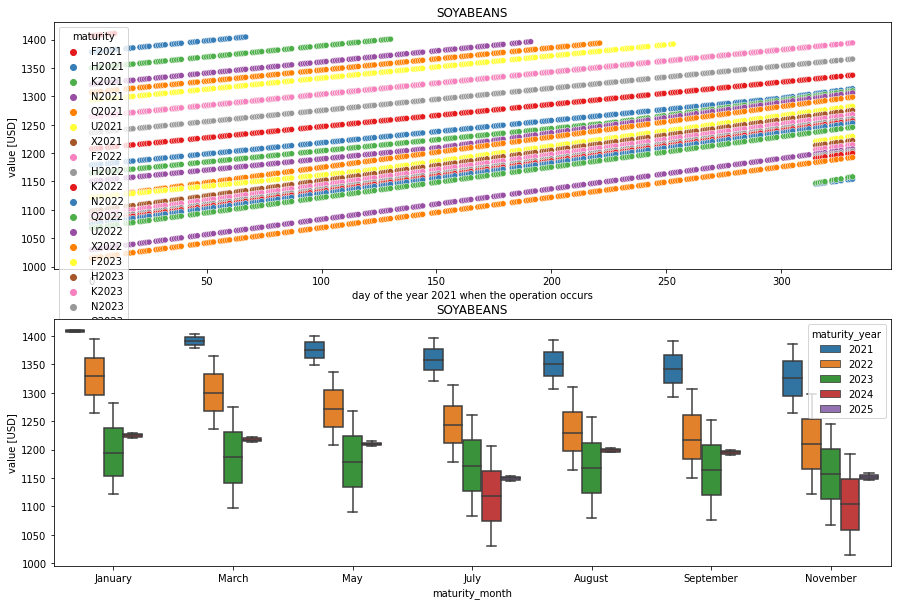

In [23]:
kind, obs = 'CBOT.ZS', 'Settle'

df_obs = df[df['observation']==obs]

results, regr = simple_network_train_and_report(
    X = df_obs[df_obs['instrument']==kind][['Ndays', 'Nmatmonth', 'Nmatyear']],
    y = df_obs[df_obs['instrument']==kind][['value']],
    max_iter = 1000,
    random_state = 123,
    params = {'Kind': kind, 'obs': obs}
)

pred = regr.predict(df_obs[df_obs['instrument']==kind][['Ndays', 'Nmatmonth', 'Nmatyear']])

df_plot = df_obs[df_obs['instrument']==kind]
df_plot['pred'] = [p for p in pred]

plot_prediciton(df_plot, kind = kind)

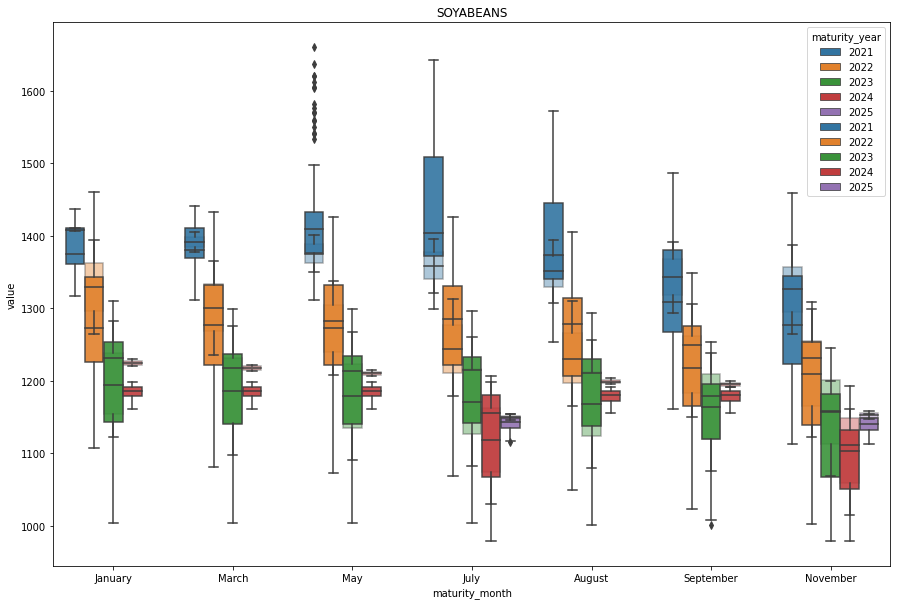

In [15]:
plot_prediciton_vs_gt(df_plot)
# Overlapping GT and PRED

### CORN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
No handles with labels found to put in legend.


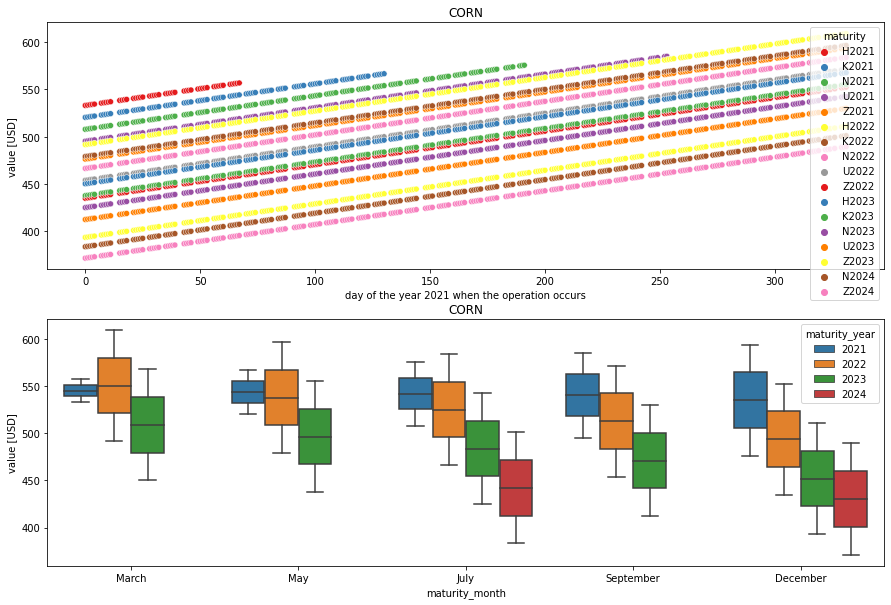

In [6]:
kind, obs = 'CBOT.ZC', 'Settle'

df_obs = df[df['observation']==obs]

results, regr = simple_network_train_and_report(
    X = df_obs[df_obs['instrument']==kind][['Ndays', 'Nmatmonth', 'Nmatyear']],
    y = df_obs[df_obs['instrument']==kind][['value']],
    max_iter = 1000,
    random_state = 123,
    params = {'Kind': kind, 'obs': obs}
)

pred = regr.predict(df_obs[df_obs['instrument']==kind][['Ndays', 'Nmatmonth', 'Nmatyear']])

df_plot = df_obs[df_obs['instrument']==kind]
df_plot['pred'] = [p for p in pred]

plot_prediciton(df_plot, kind = kind)

* The trend along current year is not well captured
* The maturity patterns, on the other hand, are well captured.
* Same happens for the CORN model

In [8]:
df_plot

,date,instrument,maturity,observation,value,currency,days,Ndays,Nmatmonth,Nmatyear,Ninstrument,maturity_month,maturity_year,Nobs,pred
10217,2021-01-04T00:00:00.000Z,CBOT.ZC,H2021,Settle,483.75,USD,0,0.000000,0.181818,0.00,0,March,2021,0.5,533.043109
10220,2021-01-04T00:00:00.000Z,CBOT.ZC,K2021,Settle,484.25,USD,0,0.000000,0.363636,0.00,0,May,2021,0.5,520.415711
10223,2021-01-04T00:00:00.000Z,CBOT.ZC,N2021,Settle,482.25,USD,0,0.000000,0.545455,0.00,0,July,2021,0.5,507.788563
10226,2021-01-04T00:00:00.000Z,CBOT.ZC,U2021,Settle,447.25,USD,0,0.000000,0.727273,0.00,0,September,2021,0.5,495.161429
10229,2021-01-04T00:00:00.000Z,CBOT.ZC,Z2021,Settle,434.50,USD,0,0.000000,1.000000,0.00,0,December,2021,0.5,476.220727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,2021-12-01T00:00:00.000Z,CBOT.ZC,N2023,Settle,557.25,USD,331,0.906849,0.545455,0.50,0,July,2023,0.5,542.504872
19013,2021-12-01T00:00:00.000Z,CBOT.ZC,U2023,Settle,515.75,USD,331,0.906849,0.727273,0.50,0,September,2023,0.5,529.877738
19016,2021-12-01T00:00:00.000Z,CBOT.ZC,Z2023,Settle,507.50,USD,331,0.906849,1.000000,0.50,0,December,2023,0.5,510.937036
19017,2021-12-01T00:00:00.000Z,CBOT.ZC,N2024,Settle,515.75,USD,331,0.906849,0.545455,0.75,0,July,2024,0.5,501.046093


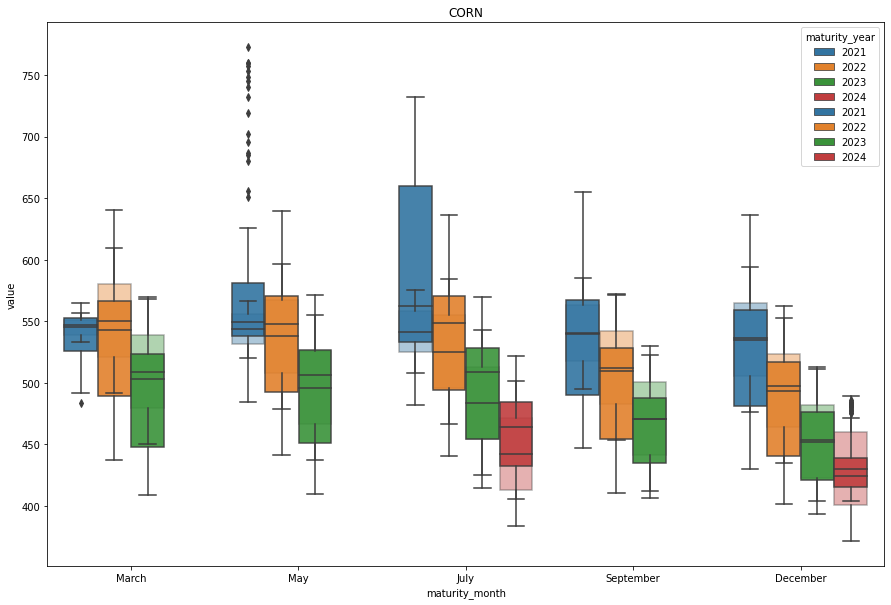

In [9]:
plot_prediciton_vs_gt(df_plot, kind = 'CBOT.ZC')
# Overlapping GT and PRED